In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def reduce_to_first_order(f_expr, order):
    """
    Reduces an nth-order ODE to a system of first-order ODEs.

    Parameters:
        f_expr : sympy expression for the nth-order ODE
        order  : the order of the ODE (e.g., 2 for y'')

    Returns:
        f_func  : a function representing the system of first-order ODEs
        Y_symbols : list of first-order variables [y, y', ..., y^(n-1)]
    """
    # Create symbols Y0, Y1, ..., Y_{order-1} representing y, y', ..., y^(n-1)
    Y_symbols = sp.symbols(' '.join([f'Y{i}' for i in range(order)]), seq=True)

    # Build a substitution map: y(x)->Y0, y'(x)->Y1, ..., y^(n-1)(x)->Y_{n-1}
    subs_map = {sp.Function('y')(x): Y_symbols[0]}
    for i in range(1, order):
        subs_map[sp.Derivative(sp.Function('y')(x), x, i)] = Y_symbols[i]

    # Substitute into the ODE to express the highest derivative in terms of Y_symbols
    f_sub = f_expr.subs(subs_map)

    # Lambdify to generate the function for numerical evaluation
    f_func = sp.lambdify((x,) + Y_symbols, f_sub, 'numpy')

    return f_func, Y_symbols

def f_system(x_val, y_vals, order, f_func):
    """
    Return the derivatives [y0', y1', ..., y_{n-1}'] for the system of first-order ODEs.

    Parameters:
        x_val : current x value
        y_vals : list of current values [y0, y1, ..., y_{n-1}]
        order : the order of the ODE
        f_func : the lambda function for the system of ODEs

    Returns:
        derivs : array of derivatives [y0', y1', ..., y_{n-1}']
    """
    derivs = np.zeros(order)

    # y0' = y1, y1' = y2, ..., y_{n-2}' = y_{n-1}
    for i in range(order-1):
        derivs[i] = y_vals[i+1]

    # Last equation: y_{n-1}' = f(x, y0, ..., y_{n-1})
    derivs[order-1] = f_func(x_val, *y_vals)

    return derivs

def runge_kutta(f_func, order, x0, initial_conditions, h, x_end):
    """
    Solve the system of first-order ODEs using the 4th-order Runge-Kutta method.

    Parameters:
        f_func : function that returns the system of derivatives
        order : the order of the ODE (e.g., 2 for y'')
        x0 : initial x value
        initial_conditions : initial values for y(0), y'(0), ..., y^(n-1)(0)
        h : step size
        x_end : end value of x

    Returns:
        xs : array of x values
        ys : array of solution values for each step
    """
    N_steps = int((x_end - x0) / h)  # number of RK4 steps
    xs = np.zeros(N_steps + 1)
    ys = np.zeros((order, N_steps + 1))

    xs[0] = x0
    ys[:, 0] = initial_conditions

    # RK4 loop
    for i in range(N_steps):
        x_curr = xs[i]
        y_curr = ys[:, i]

        # Compute RK4 slopes k1..k4 using the system function
        k1 = f_system(x_curr, y_curr, order, f_func)
        k2 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k1, order, f_func)
        k3 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k2, order, f_func)
        k4 = f_system(x_curr + h,     y_curr + h*k3, order, f_func)

        # Update solution for next step
        ys[:, i+1] = y_curr + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        xs[i+1] = x_curr + h

    return xs, ys

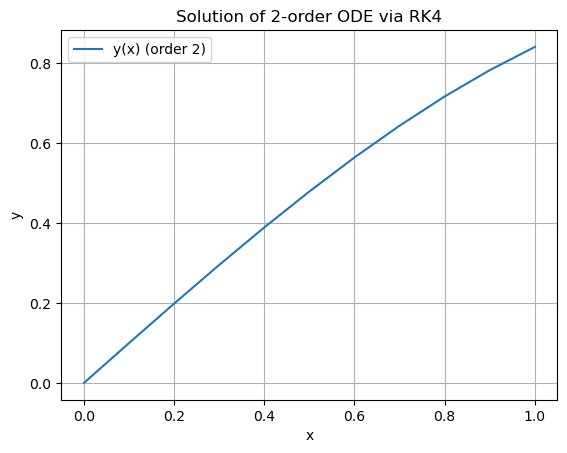

In [ ]:
xs, ys = runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

# --- Plot the solution ---
plt.plot(xs, ys[0], label=f'y(x) (order {order})')  # Plot y(x) for order 2, 3, or 4
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Solution of {order}-order ODE via RK4')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def solve_ode_particular(f_expr, order, y_var='y', x_var='x', initial_conditions=None):
    """
    Solves the particular solution of an ODE as a SymPy expression.

    Parameters:
        f_epr_expr: SymPy expression for the highest-order derivative, e.g., -y(x) for y'' = -y
        order (int): The order of the ODE (e.g., 2 for y'')
        y_var (str): The dependent variable (default: 'y')
        x_var (str): The independent variable (default: 'x')
        initial_conditions (list): Initial conditions [y(0), y'(0), ..., y^(n-1)(0)]

    Returns:
        SymPy expression for the particular solution.
    """
    x = sp.symbols(x_var)
    y = sp.Function(y_var)(x)

    # Form the ODE: highest-order derivative = f_epr_expr
    eq = sp.Eq(y.diff(x, order), f_epr)

    # Solve the ODE
    if initial_conditions:
        if len(initial_conditions) != order:
            raise ValueError(f"Initial conditions must be a list of length {order}.")
        # Convert list to SymPy initial conditions: y(0)=..., y'(0)=..., etc.
        ics = {y.subs(x, 0): initial_conditions[0]}
        for i in range(1, order):
            ics[y.diff(x, i).subs(x, 0)] = initial_conditions[i]
        sol = sp.dsolve(eq, y, ics=ics)
    else:
        sol = sp.dsolve(eq, y)

    return sol

In [ ]:
x = sp.symbols('x')
y = sp.Function('y')

# Example ODE: choose one based on order
order = 2
f_epr = -y(x) - y(x).diff(x)
initial_conditions = [0.0, 1.0]

# Get the analytical particular solution
sol = solve_ode_particular(f_epr, order, initial_conditions=initial_conditions)
print("Particular Solution:", sol)

Particular Solution: Eq(y(x), 1.15470053837925*exp(-x/2)*sin(sqrt(3)*x/2))


In [ ]:
x0 = 0.0  # initial x value
h = 0.1   # step size
x_end = 1.0  # end x value

# Reduce the ODE to a system of first-order ODEs
f_func, Y_symbols = reduce_to_first_order(f_epr, order)

# Solve the system numerically
runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([[0.        , 0.09500417, 0.18006417, 0.25531754, 0.32098196,
         0.37734559, 0.42475758, 0.463619  , 0.49437401, 0.51750163,
         0.53350778],
        [1.        , 0.9001625 , 0.80126673, 0.70416342, 0.60960528,
         0.51824919, 0.43065908, 0.34730941, 0.26858917, 0.19480631,
         0.12619252]]))

Particular Solution: Eq(y(x), 1.0*sin(x))
Maximum Absolute Error: 7.965460030234794e-06
Estimated RK4 Global Error Constant C: 0.07965460030234793


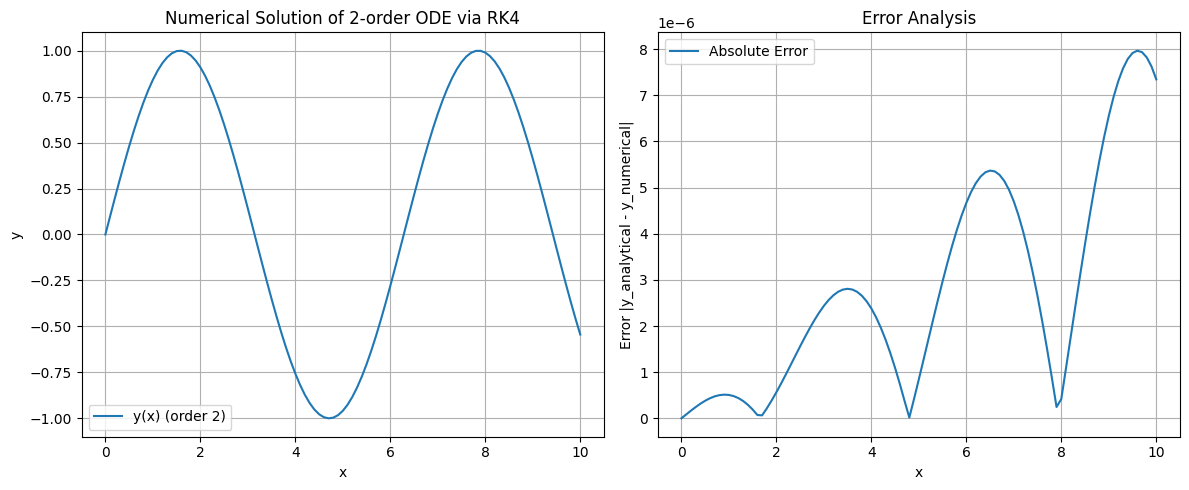

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def solve_ode_particular(f_epr_expr, order, y_var='y', x_var='x', initial_conditions=None):
    """
    Solves the particular solution of an ODE as a SymPy expression.

    Parameters:
        f_epr_expr: SymPy expression for the highest-order derivative, e.g., -y for y'' = -y
        order (int): The order of the ODE (e.g., 2 for y'')
        y_var (str): The dependent variable (default: 'y')
        x_var (str): The independent variable (default: 'x')
        initial_conditions (list): Initial conditions [y(0), y'(0), ..., y^(n-1)(0)]

    Returns:
        SymPy expression for the particular solution.
    """
    x = sp.symbols(x_var)
    y = sp.Function(y_var)(x)

    # Form the ODE: highest-order derivative = f_epr_expr
    eq = sp.Eq(y.diff(x, order), f_epr_expr)

    # Solve the ODE
    if initial_conditions:
        if len(initial_conditions) != order:
            raise ValueError(f"Initial conditions must be a list of length {order}.")
        # Convert list to SymPy initial conditions: y(0)=..., y'(0)=..., etc.
        ics = {y.subs(x, 0): initial_conditions[0]}
        for i in range(1, order):
            ics[y.diff(x, i).subs(x, 0)] = initial_conditions[i]
        sol = sp.dsolve(eq, y, ics=ics)
    else:
        sol = sp.dsolve(eq, y)

    return sol

def reduce_to_first_order(f_expr, order):
    """
    Reduces an nth-order ODE to a system of first-order ODEs.

    Parameters:
        f_expr : sympy expression for the nth-order ODE
        order  : the order of the ODE (e.g., 2 for y'')

    Returns:
        f_func  : a function representing the system of first-order ODEs
        Y_symbols : list of first-order variables [y, y', ..., y^(n-1)]
    """
    # Create symbols Y0, Y1, ..., Y_{order-1} representing y, y', ..., y^(n-1)
    Y_symbols = sp.symbols(' '.join([f'Y{i}' for i in range(order)]))

    # Build a substitution map: y(x)->Y0, y'(x)->Y1, ..., y^(n-1)(x)->Y_{n-1}
    subs_map = {sp.Function('y')(x): Y_symbols[0]}
    for i in range(1, order):
        subs_map[sp.Derivative(sp.Function('y')(x), x, i)] = Y_symbols[i]

    # Substitute into the ODE to express the highest derivative in terms of Y_symbols
    f_sub = f_expr.subs(subs_map)

    # Lambdify to generate the function for numerical evaluation
    f_func = sp.lambdify((x,) + Y_symbols, f_sub, 'numpy')

    return f_func, Y_symbols

def f_system(x_val, y_vals, order, f_func):
    """
    Return the derivatives [y0', y1', ..., y_{n-1}'] for the system of first-order ODEs.

    Parameters:
        x_val : current x value
        y_vals : list of current values [y0, y1, ..., y_{n-1}]
        order : the order of the ODE
        f_func : the lambda function for the system of ODEs

    Returns:
        derivs : array of derivatives [y0', y1', ..., y_{n-1}']
    """
    derivs = np.zeros(order)

    # y0' = y1, y1' = y2, ..., y_{n-2}' = y_{n-1}
    for i in range(order-1):
        derivs[i] = y_vals[i+1]

    # Last equation: y_{n-1}' = f(x, y0, ..., y_{n-1})
    derivs[order-1] = f_func(x_val, *y_vals)

    return derivs

def runge_kutta(f_func, order, x0, initial_conditions, h, x_end):
    """
    Solve the system of first-order ODEs using the 4th-order Runge-Kutta method.

    Parameters:
        f_func : function that returns the system of derivatives
        order : the order of the ODE (e.g., 2 for y'')
        x0 : initial x value
        initial_conditions : initial values for y(0), y'(0), ..., y^(n-1)(0)
        h : step size
        x_end : end value of x

    Returns:
        xs : array of x values
        ys : array of solution values for each step
    """
    N_steps = int((x_end - x0) / h)  # number of RK4 steps
    xs = np.zeros(N_steps + 1)
    ys = np.zeros((order, N_steps + 1))

    xs[0] = x0
    ys[:, 0] = initial_conditions

    # RK4 loop
    for i in range(N_steps):
        x_curr = xs[i]
        y_curr = ys[:, i]

        # Compute RK4 slopes k1..k4 using the system function
        k1 = f_system(x_curr, y_curr, order, f_func)
        k2 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k1, order, f_func)
        k3 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k2, order, f_func)
        k4 = f_system(x_curr + h,     y_curr + h*k3, order, f_func)

        # Update solution for next step
        ys[:, i+1] = y_curr + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        xs[i+1] = x_curr + h

    return xs, ys

def compute_error(analytical_sol, xs, ys, h, x_var='x'):
    """
    Computes the error between the analytical and numerical solutions and estimates the RK4 global error constant.

    Parameters:
        analytical_sol: SymPy expression for the analytical solution (from solve_ode_particular)
        xs: Array of x values from numerical solution
        ys: Array of numerical solution values [y, y', ..., y^(n-1)]
        h: Step size used in numerical solution
        x_var (str): Independent variable (default: 'x')

    Returns:
        errors: Array of absolute errors |y_analytical - y_numerical|
        C_estimate: Estimated constant C for RK4 global error E ≈ C h^4
    """
    x = sp.symbols(x_var)

    # Extract the right-hand side of the analytical solution (e.g., sin(x) from Eq(y(x), sin(x)))
    y_analytical_expr = analytical_sol.rhs

    # Convert analytical solution to a numerical function
    y_analytical_func = sp.lambdify(x, y_analytical_expr, 'numpy')

    # Compute analytical solution at xs
    y_analytical = y_analytical_func(xs)

    # Compute absolute error: |y_analytical - y_numerical|
    errors = np.abs(y_analytical - ys[0])  # ys[0] is the numerical y(x)

    # Estimate global error constant C: E ≈ C h^4, so C ≈ E / h^4
    # Use the maximum error as the global error estimate
    max_error = np.max(errors)
    C_estimate = max_error / (h**4) if h != 0 else 0

    return errors, C_estimate

# --- Example usage for a 2nd, 3rd, or 4th order ODE ---

# Define the symbolic independent variable and function
x = sp.symbols('x')
y = sp.Function('y')(x)

# Example ODE: choose one based on order
order = 2  # Choose order: 2 for y'', 3 for y''', 4 for y'''' etc.

# Define the ODE (f_epr is the highest-order derivative)
if order == 2:
    f_epr = -y  # y'' = -y
elif order == 3:
    f_epr = -y - y.diff(x)  # y''' = -y - y'
elif order == 4:
    f_epr = -y - y.diff(x, 2)  # y'''' = -y - y''
else:
    raise ValueError("Order not supported. Use 2, 3, or 4.")

# Initial conditions: [y(0), y'(0), ..., y^(n-1)(0)] for respective orders
initial_conditions = [0.0, 1.0] if order == 2 else [0.0, 1.0, 0.0] if order == 3 else [0.0, 1.0, 0.0, 0.0]

# Get the analytical particular solution
sol = solve_ode_particular(f_epr, order, initial_conditions=initial_conditions)
print("Particular Solution:", sol)

# Integration parameters for numerical solution
x0 = 0.0  # initial x value
h = 0.1   # step size
x_end = 10.0  # end x value

# Reduce the ODE to a system of first-order ODEs
f_func, Y_symbols = reduce_to_first_order(f_epr, order)

# Solve the system numerically
xs, ys = runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

# Compute error and RK4 global error constant
errors, C_estimate = compute_error(sol, xs, ys, h)
print("Maximum Absolute Error:", np.max(errors))
print("Estimated RK4 Global Error Constant C:", C_estimate)

# --- Plot the numerical solution and error ---
plt.figure(figsize=(12, 5))

# Plot numerical solution
plt.subplot(1, 2, 1)
plt.plot(xs, ys[0], label=f'y(x) (order {order})')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Numerical Solution of {order}-order ODE via RK4')
plt.legend()
plt.grid(True)

# Plot error
plt.subplot(1, 2, 2)
plt.plot(xs, errors, label='Absolute Error')
plt.xlabel('x')
plt.ylabel('Error |y_analytical - y_numerical|')
plt.title('Error Analysis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def solve_ode_particular(ode_expr, order, y_var='y', x_var='x', initial_conditions=None):
    """
    Solves the particular solution of an ODE as a SymPy expression.

    Parameters:
        ode_expr: SymPy expression for the ODE, e.g., y.diff(x, 3) + 2*y.diff(x, 2) - y.diff(x) + y - sin(x)
        order (int): The order of the ODE (e.g., 3 for y''')
        y_var (str): The dependent variable (default: 'y')
        x_var (str): The independent variable (default: 'x')
        initial_conditions (list): Initial conditions [y(0), y'(0), ..., y^(n-1)(0)]

    Returns:
        SymPy expression for the particular solution.
    """
    x = sp.symbols(x_var)
    y = sp.Function(y_var)(x)

    # Form the ODE: ode_expr = 0
    eq = sp.Eq(ode_expr, 0)

    # Solve the ODE
    if initial_conditions:
        if len(initial_conditions) != order:
            raise ValueError(f"Initial conditions must be a list of length {order}.")
        # Convert list to SymPy initial conditions: y(0)=..., y'(0)=..., etc.
        ics = {y.subs(x, 0): initial_conditions[0]}
        for i in range(1, order):
            ics[y.diff(x, i).subs(x, 0)] = initial_conditions[i]
        sol = sp.dsolve(eq, y, ics=ics)
    else:
        sol = sp.dsolve(eq, y)

    return sol

def reduce_to_first_order(f_expr, order):
    """
    Reduces an nth-order ODE to a system of first-order ODEs.

    Parameters:
        f_expr : sympy expression for the highest-order derivative
        order  : the order of the ODE (e.g., 3 for y''')

    Returns:
        f_func  : a function representing the system of first-order ODEs
        Y_symbols : list of first-order variables [y, y', ..., y^(n-1)]
    """
    x = sp.symbols('x')
    y = sp.Function('y')(x)
    Y_symbols = sp.symbols(' '.join([f'Y{i}' for i in range(order)]))

    # Build substitution map: y->Y0, y'->Y1, ..., y^(n-1)->Y_{n-1}
    subs_map = {y: Y_symbols[0]}
    for i in range(1, order):
        subs_map[y.diff(x, i)] = Y_symbols[i]

    # Substitute into the expression for the highest derivative
    f_sub = f_expr.subs(subs_map)

    # Lambdify for numerical evaluation
    f_func = sp.lambdify((x,) + tuple(Y_symbols), f_sub, 'numpy')

    return f_func, Y_symbols

def f_system(x_val, y_vals, order, f_func):
    """
    Return the derivatives [y0', y1', ..., y_{n-1}'] for the system of first-order ODEs.

    Parameters:
        x_val : current x value
        y_vals : list of current values [y0, y1, ..., y_{n-1}]
        order : the order of the ODE
        f_func : the lambda function for the system of ODEs

    Returns:
        derivs : array of derivatives [y0', y1', ..., y_{n-1}']
    """
    derivs = np.zeros(order)

    # y0' = y1, y1' = y2, ..., y_{n-2}' = y_{n-1}
    for i in range(order-1):
        derivs[i] = y_vals[i+1]

    # Last equation: y_{n-1}' = f(x, y0, ..., y_{n-1})
    derivs[order-1] = f_func(x_val, *y_vals)

    return derivs

def runge_kutta(f_func, order, x0, initial_conditions, h, x_end):
    """
    Solve the system of first-order ODEs using the 4th-order Runge-Kutta method.

    Parameters:
        f_func : function that returns the system of derivatives
        order : the order of the ODE (e.g., 3 for y''')
        x0 : initial x value
        initial_conditions : initial values for y(0), y'(0), ..., y^(n-1)(0)
        h : step size
        x_end : end value of x

    Returns:
        xs : array of x values
        ys : array of solution values for each step
    """
    N_steps = int((x_end - x0) / h) + 1  # number of RK4 steps
    xs = np.linspace(x0, x_end, N_steps)
    ys = np.zeros((order, N_steps))

    ys[:, 0] = initial_conditions

    # RK4 loop
    for i in range(N_steps-1):
        x_curr = xs[i]
        y_curr = ys[:, i]

        k1 = f_system(x_curr, y_curr, order, f_func)
        k2 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k1, order, f_func)
        k3 = f_system(x_curr + 0.5*h, y_curr + 0.5*h*k2, order, f_func)
        k4 = f_system(x_curr + h,     y_curr + h*k3, order, f_func)

        ys[:, i+1] = y_curr + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    return xs, ys

def compute_error(analytical_sol, xs, ys, h, x_var='x'):
    """
    Computes the error between the analytical and numerical solutions and estimates the RK4 global error constant.

    Parameters:
        analytical_sol: SymPy expression for the analytical solution
        xs: Array of x values from numerical solution
        ys: Array of numerical solution values [y, y', ..., y^(n-1)]
        h: Step size used in numerical solution
        x_var (str): Independent variable (default: 'x')

    Returns:
        errors: Array of absolute errors |y_analytical - y_numerical|
        C_estimate: Estimated constant C for RK4 global error E ≈ C h^4
        y_analytical: Analytical solution evaluated at xs
    """
    x = sp.symbols(x_var)
    y_analytical_expr = analytical_sol.rhs
    y_analytical_func = sp.lambdify(x, y_analytical_expr, 'numpy')
    y_analytical = y_analytical_func(xs)
    errors = np.abs(y_analytical - ys[0])
    max_error = np.max(errors)
    C_estimate = max_error / (h**4) if h != 0 else 0
    return errors, C_estimate, y_analytical

# --- Example usage for a 3rd order ODE ---

# Define the symbolic independent variable and function
x = sp.symbols('x')
y = sp.Function('y')(x)

# Example ODE: y''' + 2y'' - y' + y = sin(x)
order = 3
ode_expr = y.diff(x, 3) + 2*y.diff(x, 2) - y.diff(x) + y - sp.sin(x)
f_epr = sp.solve(sp.Eq(ode_expr, 0), y.diff(x, order))[0]  # Solve for y''' = -2y'' + y' - y + sin(x)

# Initial conditions: [y(0), y'(0), y''(0)]
initial_conditions = [1.0, 0.0, -1.0]

# Get the analytical particular solution
sol = solve_ode_particular(ode_expr, order, initial_conditions=initial_conditions)
print("Particular Solution:", sol)

# Integration parameters for numerical solution
x0 = 0.0
h = 0.1
x_end = 1.0

# Reduce the ODE to a system of first-order ODEs
f_func, Y_symbols = reduce_to_first_order(f_epr, order)

# Solve the system numerically
xs, ys = runge_kutta(f_func, order, x0, initial_conditions, h, x_end)

# Compute error and RK4 global error constant
errors, C_estimate, y_analytical = compute_error(sol, xs, ys, h)
print("\nMaximum Absolute Error:", np.max(errors))
print("Estimated RK4 Global Error Constant C:", C_estimate)

# --- Create tables for output ---
# Solution and Error Table (limited to first 10 points for brevity)
table_data = [
    [x_val, y_ana, y_num, err]
    for x_val, y_ana, y_num, err in zip(xs, y_analytical, ys[0], errors)
][:10]  # Limit to first 10 rows
headers = ['x', 'y_analytical', 'y_numerical', 'Absolute Error']
print("\nSolution and Error Table (First 10 Points):")
print(tabulate(table_data, headers=headers, tablefmt='grid', floatfmt='.6f'))

# Summary Table
summary_data = [
    ["Particular Solution", str(sol)],
    ["Maximum Absolute Error", np.max(errors)],
    ["RK4 Global Error Constant C", C_estimate],
    ["Step Size (h)", h],
    ["Order of ODE", order]
]
print("\nSummary Table:")
print(tabulate(summary_data, headers=['Parameter', 'Value'], tablefmt='grid', floatfmt='.6f'))

# --- Plot the numerical solution and error ---
plt.figure(figsize=(12, 5))

# Plot numerical and analytical solutions
plt.subplot(1, 2, 1)
plt.plot(xs, ys[0], label=f'y_numerical(x) (order {order})')
plt.plot(xs, y_analytical, label='y_analytical(x)', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Solution of {order}-order ODE')
plt.legend()
plt.grid(True)

# Plot error
plt.subplot(1, 2, 2)
plt.plot(xs, errors, label='Absolute Error')
plt.xlabel('x')
plt.ylabel('Error |y_analytical - y_numerical|')
plt.title('Error Analysis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()